# Download The Data

In [1]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:30<00:00, 97.0MB/s]


#### Unzip The Folder of images

In [2]:
!unzip -q instance-level-human-parsing.zip

In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
def create_dataset(folder_path, folder_type):
    images = sorted(
        glob.glob(folder_path + "/" + folder_type + "/Images/*.jpg")
    )  # get the paths of images and sort them
    masks = sorted(
        glob.glob(folder_path + "/" + folder_type + "/Category_ids/*.png")
    )  # get the paths of mask and sort them

    data = {"images": images, "masks": masks}

    return pd.DataFrame(data)  # return the pandas dataframe


train_data = create_dataset("/content/instance-level_human_parsing/instance-level_human_parsing", "Training")
val_data = create_dataset("/content/instance-level_human_parsing/instance-level_human_parsing", "Validation")

In [5]:
len(train_data) , len(val_data)

(28280, 5000)

In [6]:
NUM_CLASSES = 20

In [7]:
def read_image(x, y):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x, [256, 256])
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

    y = tf.io.read_file(y)
    y = tf.image.decode_png(y, channels=1)
    y = tf.image.resize(y, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    y = tf.reshape(y, shape=(256, 256))
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x, y

def train_preprocess(x, y):
    seed = np.random.randint(low=0, high=100, size=1)

    tf.compat.v1.set_random_seed(seed)
    x = tf.image.random_flip_left_right(x, seed=seed[0])

    x = tf.image.random_brightness(x, max_delta=32.0 / 255.0)
    x = tf.image.random_saturation(x, lower=0.5, upper=1.5)

    x = tf.clip_by_value(x, 0.0, 1.0)

    y = tf.argmax(y, axis=-1)
    y = tf.reshape(y, shape=(256, 256, 1))
    y = tf.image.random_flip_left_right(y, seed=seed[0])
    y = tf.reshape(y, shape=(256, 256))
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x, y

# Data Pipeline

In [8]:
def dataset_creater(x, y, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(1028, reshuffle_each_iteration=True)
    data = data.map(
        read_image, num_parallel_calls=tf.data.AUTOTUNE
    ) 

    if training:
        data = data.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


train_dataset = dataset_creater(train_data.images, train_data.masks, training=True)
test_dataset = dataset_creater(val_data.images, val_data.masks)

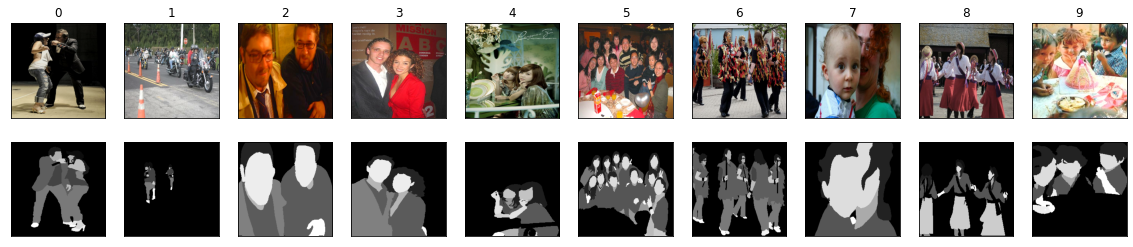

In [9]:
n = 10
plt.figure(figsize=(20, 4))

for x, y in train_dataset.take(1):

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, n + i + 1)

        plt.imshow(tf.squeeze(tf.argmax(y[i], -1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

plt.show()

# U-Net
U-Net is an architecture for semantic segmentation. It consists of a contracting path (encoder) and an expansive path (decoder). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a BatchNormalization than (Leaky_relu) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a BatchNormalization than (Leaky_relu). At the final layer a 1x1 convolution is used to map each 32-component feature vector to the desired number of classes.

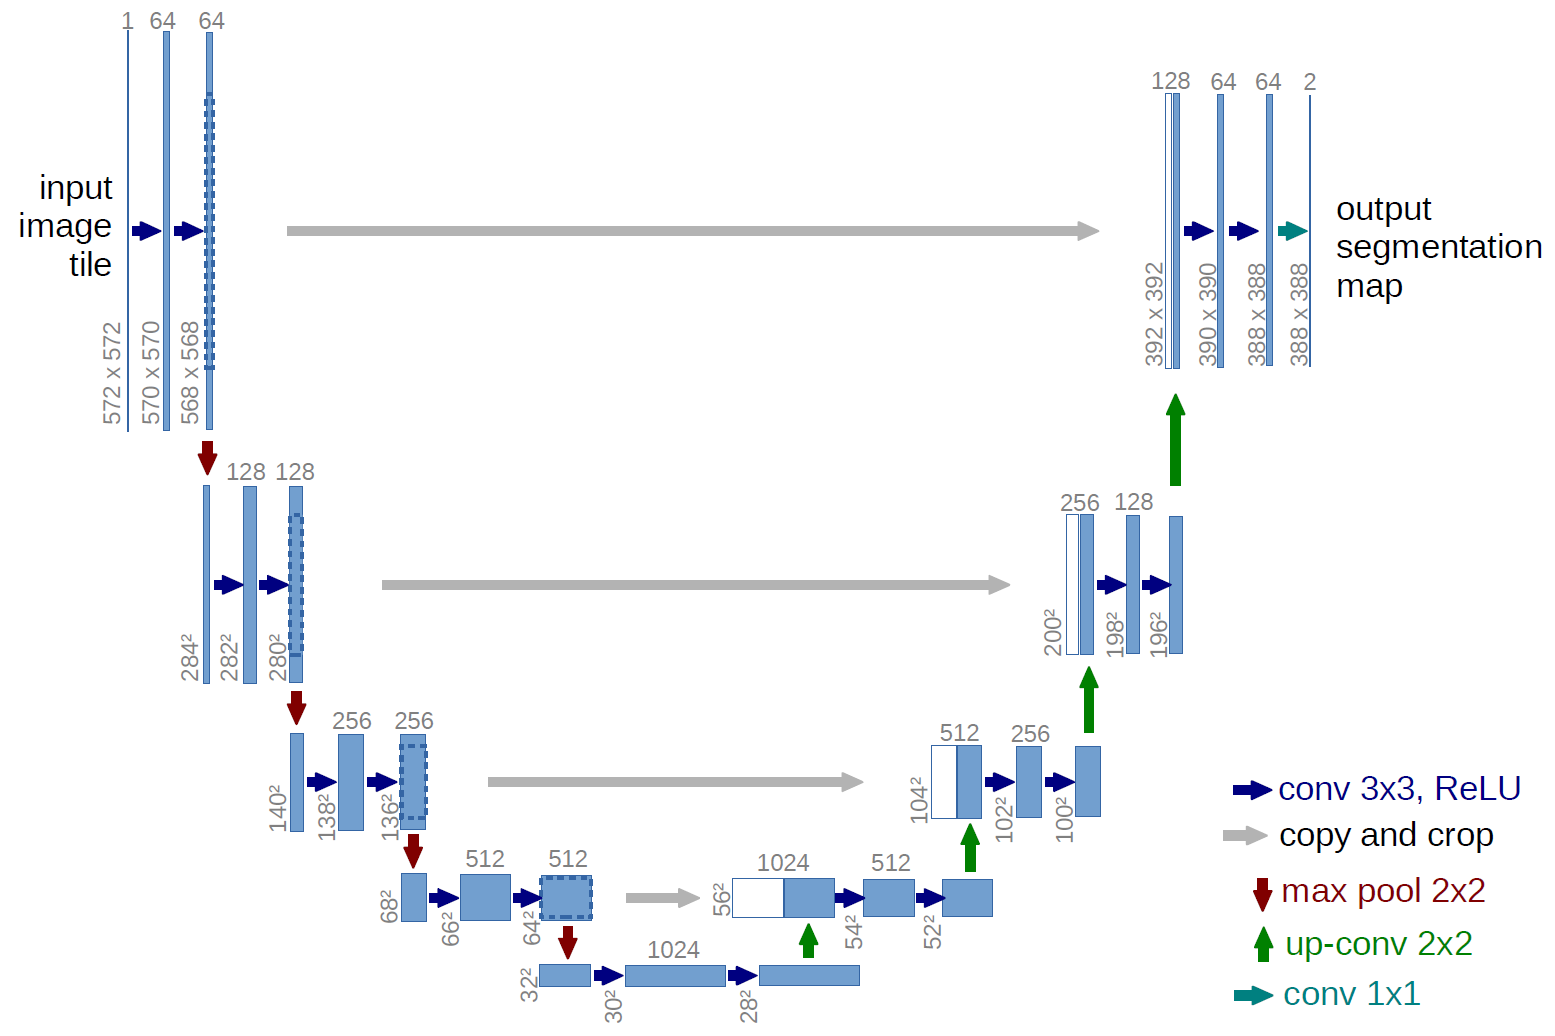

# Convolution Block



In [10]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()

        self.Conv_1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=(3, 3), padding="same", use_bias=False
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        
        self.Conv_2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=(3, 3), padding="same", use_bias=False
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)

        return x

# Encoder Block

In [11]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(EncoderBlock, self).__init__()
        self.Conv_block = ConvBlock(filters)
        self.Max_pool = tf.keras.layers.MaxPooling2D()

    def call(self, x):
        x = self.Conv_block(x)
        p = self.Max_pool(x)
        return x, p

# Decoder Block

In [12]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.ConvTranspose = tf.keras.layers.Conv2DTranspose(
            filters, kernel_size=(2, 2), strides=(2, 2), padding="same"
        )
        self.Conv_block = ConvBlock(filters)

    def call(self, input, skip_features):
        x = self.ConvTranspose(input)
        x = tf.keras.layers.concatenate([x, skip_features])
        x = self.Conv_block(x)
        return x

# the U-Net Model

In [13]:
class SemanticSegmentation(tf.keras.Model):
    def __init__(self, n_classes=NUM_CLASSES):
        super(SemanticSegmentation, self).__init__()

        self.encoder_block_1 = EncoderBlock(32)
        self.encoder_block_2 = EncoderBlock(64)
        self.encoder_block_3 = EncoderBlock(128)
        self.encoder_block_4 = EncoderBlock(256)
        self.encoder_block_5 = EncoderBlock(512)
        self.encoder_block_6 = EncoderBlock(1024)

        self.conv_block_7 = ConvBlock(1028)
        
        self.decoder_block_8 = DecoderBlock(1024)
        self.decoder_block_9 = DecoderBlock(512)
        self.decoder_block_10 = DecoderBlock(256)
        self.decoder_block_11 = DecoderBlock(128)
        self.decoder_block_12 = DecoderBlock(64)
        self.decoder_block_13 = DecoderBlock(32)

        self.out = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1))

    def call(self, x):
        s1, x = self.encoder_block_1(x)
        s2, x = self.encoder_block_2(x)
        s3, x = self.encoder_block_3(x)
        s4, x = self.encoder_block_4(x)
        s5, x = self.encoder_block_5(x)
        s6, x = self.encoder_block_6(x)

        x = self.conv_block_7(x)
        
        x = self.decoder_block_8(x, s6)
        x = self.decoder_block_9(x, s5)
        x = self.decoder_block_10(x, s4)
        x = self.decoder_block_11(x, s3)
        x = self.decoder_block_12(x, s2)
        x = self.decoder_block_13(x, s1)
        x = self.out(x)
        x = tf.nn.softmax(x)

        return x

    def build_model(self, dim=(256, 256, 3)):
        x = tf.keras.layers.Input(dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])

In [14]:
model = SemanticSegmentation()
model.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block (EncoderBlock)   ((None, 256, 256, 3  10336       ['input_1[0][0]']                
                                2),                                                               
                                 (None, 128, 128, 3                                               
                                2))                                                               
                                                                                              

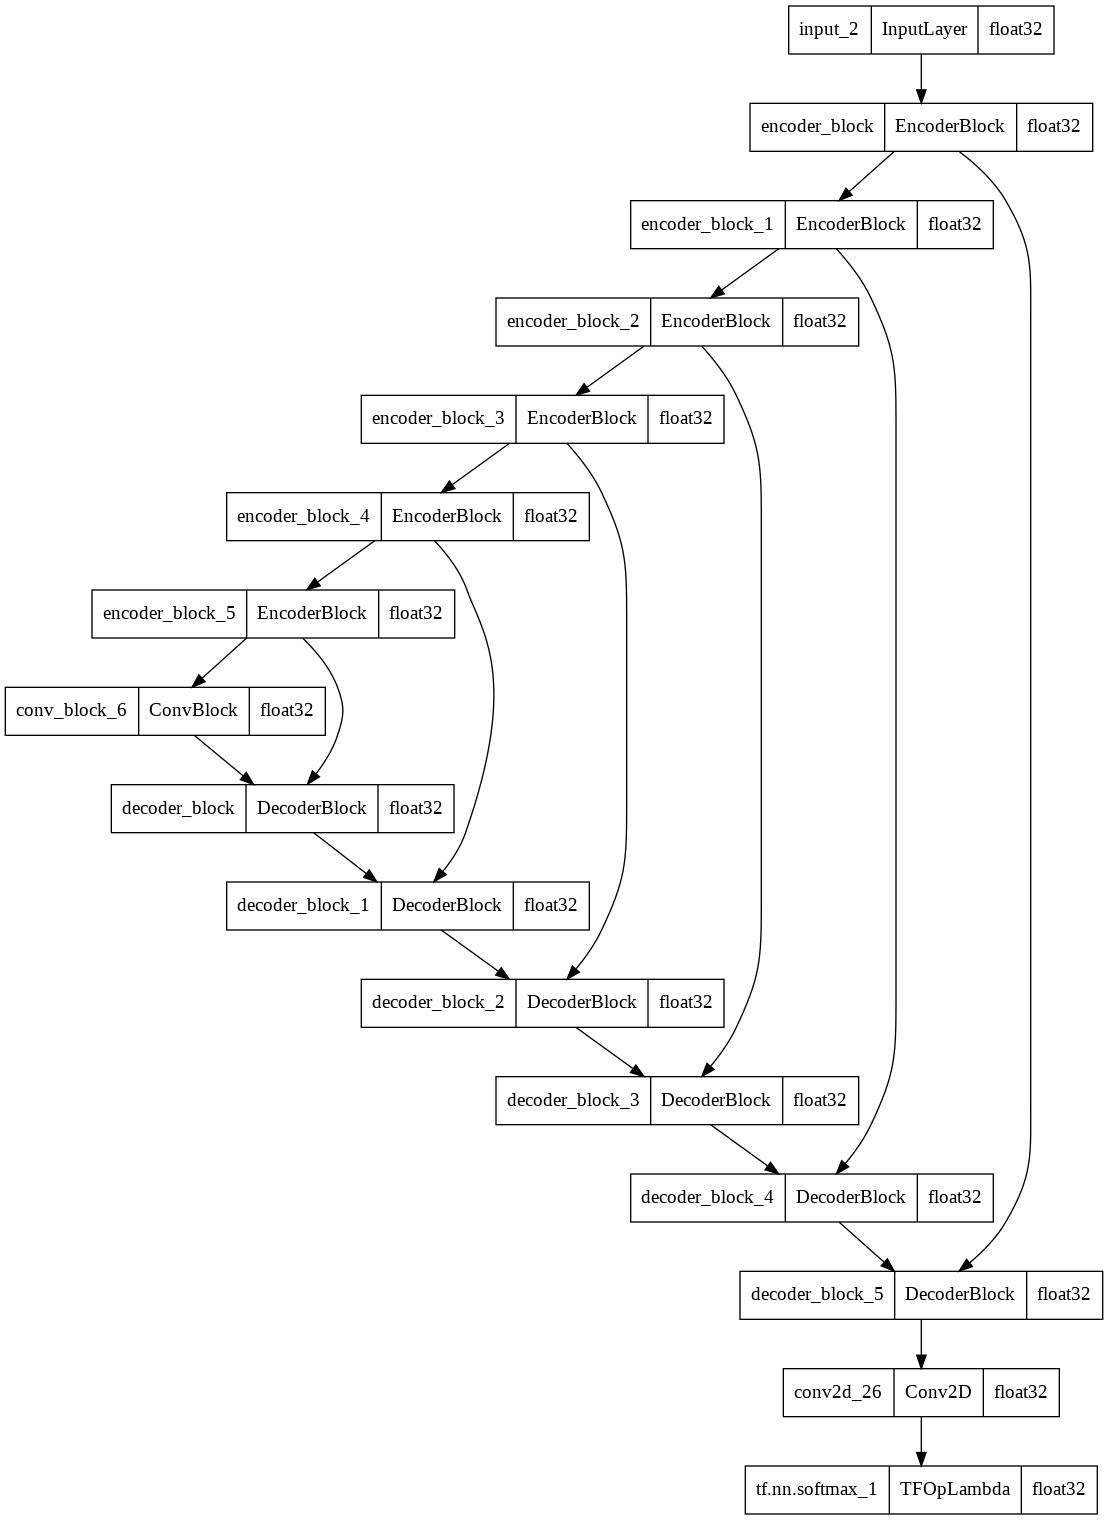

In [15]:
tf.keras.utils.plot_model(model.build_model(), show_dtype=True)

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=["acc"]
)
model.fit(train_dataset, epochs=10, validation_data=test_dataset,batch_size=32)

Epoch 1/10
884/884 [==============================] - 791s 864ms/step - loss: 1.0746 - acc: 0.6745 - val_loss: 0.8332 - val_acc: 0.7320
Epoch 2/10
884/884 [==============================] - 753s 851ms/step - loss: 0.7590 - acc: 0.7478 - val_loss: 0.7464 - val_acc: 0.7559
Epoch 3/10
884/884 [==============================] - 752s 851ms/step - loss: 0.6743 - acc: 0.7739 - val_loss: 0.6442 - val_acc: 0.7848
Epoch 4/10
884/884 [==============================] - 753s 851ms/step - loss: 0.6230 - acc: 0.7894 - val_loss: 0.6496 - val_acc: 0.7866
Epoch 5/10
884/884 [==============================] - 752s 850ms/step - loss: 0.5891 - acc: 0.8005 - val_loss: 0.5628 - val_acc: 0.8093
Epoch 6/10
884/884 [==============================] - 753s 851ms/step - loss: 0.5663 - acc: 0.8083 - val_loss: 0.5655 - val_acc: 0.8084
Epoch 7/10
884/884 [==============================] - 753s 851ms/step - loss: 0.5405 - acc: 0.8158 - val_loss: 0.5405 - val_acc: 0.8152
Epoch 8/10
884/884 [============================

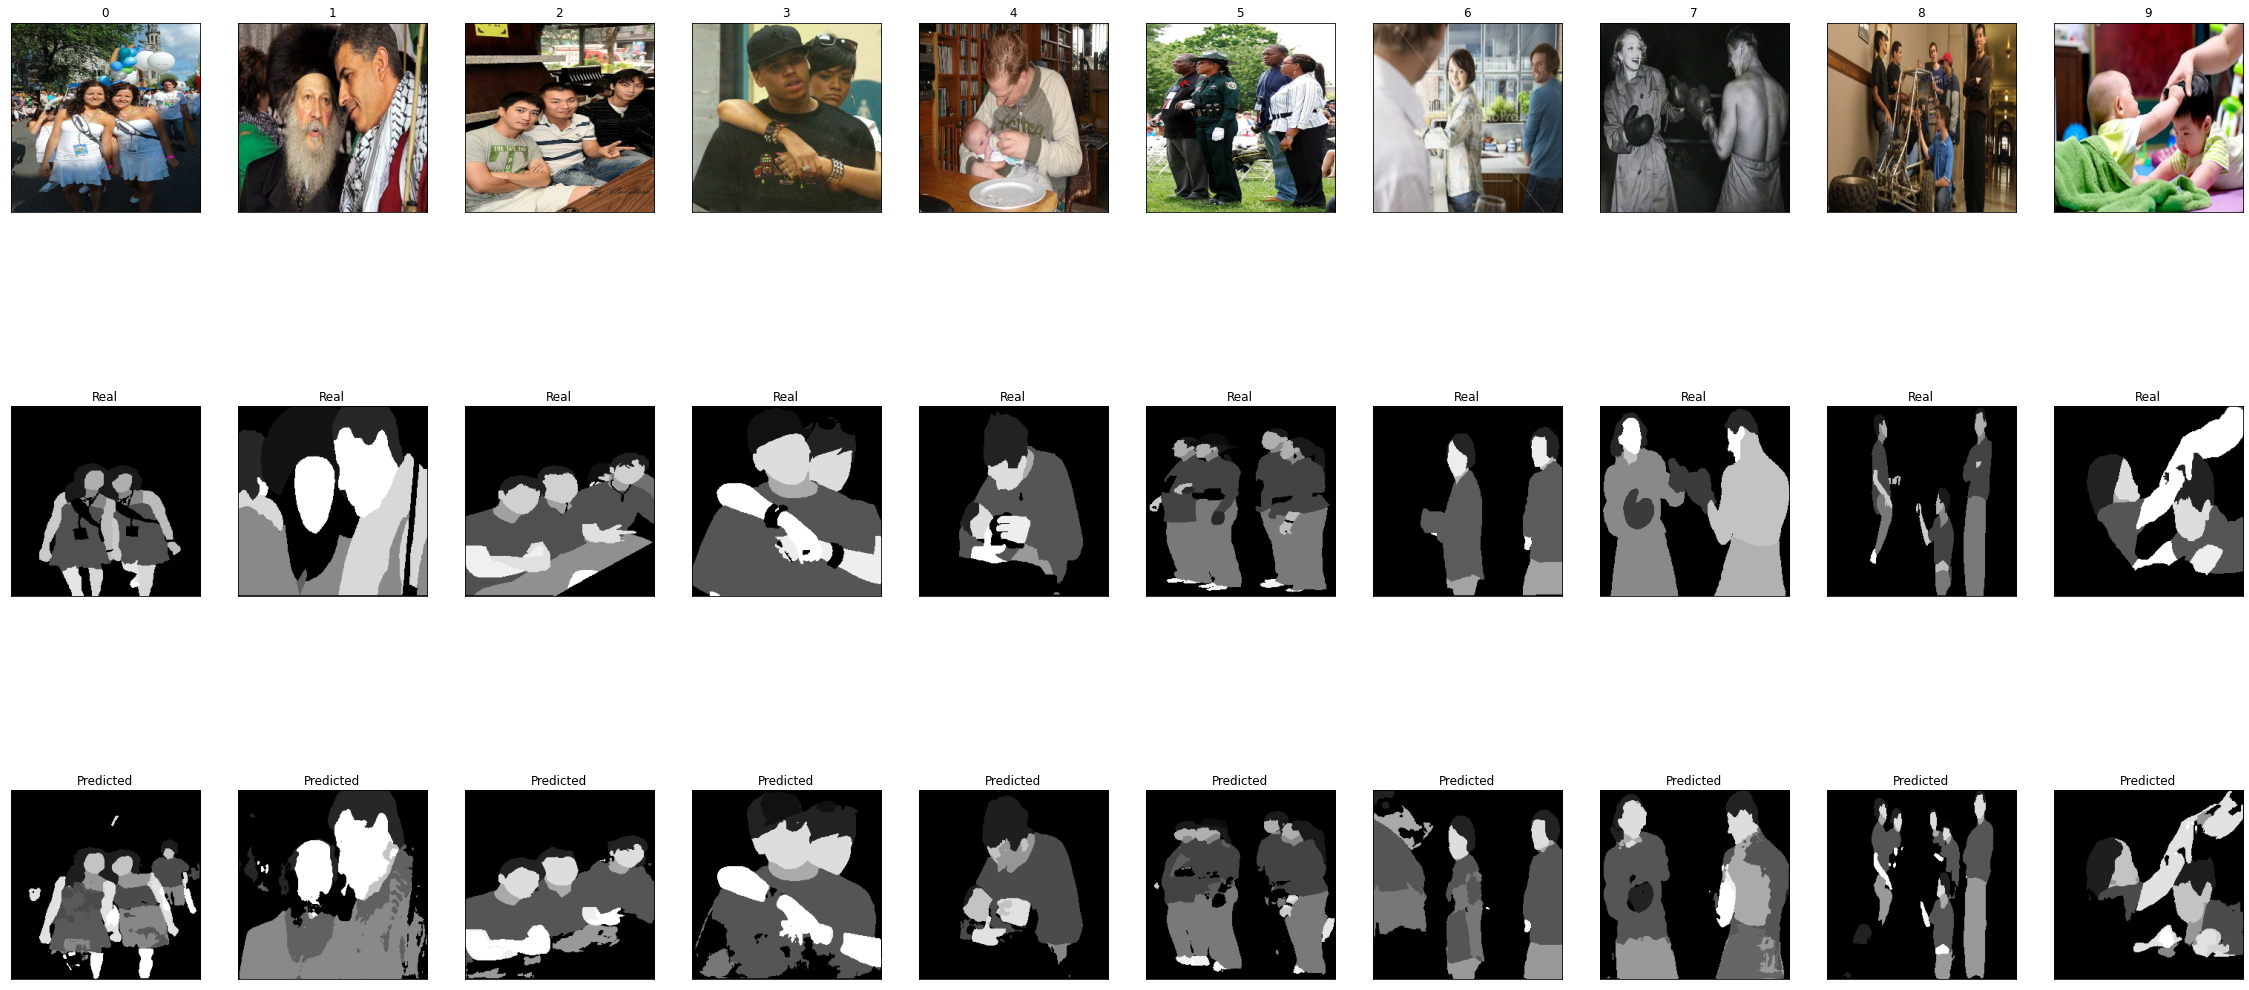

In [26]:
for x, y in test_dataset.take(1):
    pred = model(x, training=False)
    pred = tf.argmax(pred, axis=-1)
    n = 10
    plt.figure(figsize=(40, 20))

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)

        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(3, n, n + i + 1)

        plt.title('Real')
        plt.imshow(tf.squeeze(tf.argmax(y[i], axis=-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

        cx = plt.subplot(3, n, n + i + n + 1)

        plt.title('Predicted')
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)


plt.show()

In [20]:
model.save('Semantic_Segmenation')